# Example 4 - Nitrogen-doped carbon catalysts

In this example, we will use Bayesian Optimization to faciliate the synthesis of nitrogen-doped carbon (NDC) catalysts. NDCs have been found to perform electrochemical hydrogen evolution reactions (HER), providing a cheaper but equally efficient alternative to Pt-baseved materials. We would like to find a "magic" formula for synthesis conditions where the catalyst performance is optimized. 

For synthesis, the final temperature (`X1`), the heating rate (`X2`) and the hold time (`X3`) at the maximum temperature are selected as tunable parameters. These parameters define a 3D experimental synthesis. 

The nitrogen species are the active sites for HER reactions. From literature, many studies report that the higher the nitrogen (N) content, the higher the performance. Thus, we choose the N content of the catalyst as the reponse `Y`. 

There is no analytical objective function available in this example. The reponses are measured from experimental characterization techniques given the systhesis conditions. When there is a function that we cannot access but we can only observe its outputs based on some given inputs, it is called a black-box function. We call the process of optimizing these input parameters as black box optimization. 




The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :------------------------------------ |
| Goal | Maximization |
| Objective function | NDC catalyst synthesis experiments |
| Input (X) dimension | 3 |
| Output (Y) dimension | 1 |
| Analytical form available? | No |
| Acqucision function | Expected improvement (EI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.


## 1. Import `nextorch` and other packages

In [1]:
import os
import sys
project_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_path)

import numpy as np
from IPython.display import display
from nextorch import plotting, bo, doe, io, utils

## 2. Define the design space 
We set the names and units for input parameters and output reponses. Their reasonable operating ranges are also defined. 

In [2]:
# Three input final temperature, heating rate, hold time
X_name_list = ['T', 'Heating rate', 'Time']
X_units = ['C', 'C/min', 'hr']
X_units_plot = [r'$\rm ^oC $', r'$\rm ^oC/min $', 'hr']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)

# Create latex-like strings for plotting purposes
X_name_with_unit_plot = []
for i, var in enumerate(X_name_list):
    if not X_units_plot[i]  == '':
        var = var + ' ('+ X_units_plot[i] + ')'
    X_name_with_unit_plot.append(var)

# One output
Y_name_with_unit = 'N_Content'
Y_name_with_unit_plot = r'$\rm N_{Content}%$'

# combine X and Y names
var_names = X_name_with_unit + [Y_name_with_unit]

# Set the operating range for each parameter
X_ranges = [[300, 500], # Temperature ranges from 300-500 degree C
            [3, 8], # Heating rate ranges from 3-8 degree C per minuate
            [2, 6]] # hold time ranges from 2-6 hours 

# Set the reponse range
Y_plot_range = [0, 2.5]

# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = 1 # the dimension of outputs
n_trials = 4 # number of experiment iterations

## 3. Define the initial sampling plan
We don't have an objective function in this example. All the synthesis data are collected from experiments, saved in a csv file. Here we assume we already complete 4 Bayesian Optimization iterations. The trial number column in the full data incidates the iteration index (from 0 to 4). 

We use the `io` moledule in `nextorch` to help us with the data import and preprocessing. `io` is built on the Python library `pandas` and shares many similiarities. 


Input data contains 22 points, 4 variables:
	T (C), Heating rate (C/min), Time (hr), N_Content
The input data: 


,T (C),Heating rate (C/min),Time (hr),N_Content
0,370,7.75,4.36,1.834
1,490,4.75,2.36,1.161
2,330,5.25,3.24,0.718
3,410,6.75,2.12,1.575
4,450,4.25,4.12,1.300


The full data in the csv file: 


,Trial,T (C),Heating rate (C/min),Time (hr),N_Content
0,0,370,7.75,4.36,1.834
1,0,490,4.75,2.36,1.161
2,0,330,5.25,3.24,0.718
3,0,410,6.75,2.12,1.575
4,0,450,4.25,4.12,1.300


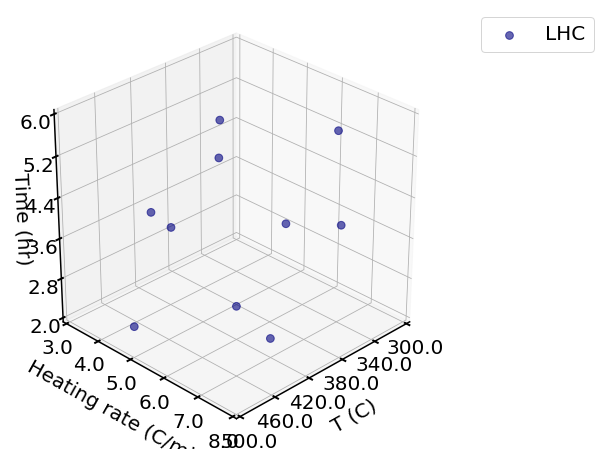

In [3]:
# Import data from a csv file 
file_path = os.path.join(project_path, 'examples', 'NDC_catalyst', 'synthesis_data.csv')
# Extract the data of interest and also the full data 
data, data_full = io.read_csv(file_path, var_names = var_names)

# take a look at the first 5 data points
print("The input data: ")
display(data.head(5))

print("The full data in the csv file: ")
display(data_full.head(5))

# Split data into X and Y given the Y name
X_real, Y_real, _, _ = io.split_X_y(data, Y_names = Y_name_with_unit)

# Extract the iteration index
trial_no = data_full['Trial']

# Initial Data 
X_init_real = X_real[trial_no==0]
Y_init_real = Y_real[trial_no==0]


# Assume we run Latin hypder cube to create the initial samplinmg
#n_init_lhc = 10
#X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc)

# Create the initial sampling plan and responses from the data
X_init_real = X_real[trial_no==0]
Y_init_real = Y_real[trial_no==0]

# Convert the sampling plan to a unit scale
X_init = utils.unitscale_X(X_init_real, X_ranges)

# Visualize the sampling plan, 
# Sampling_3d takes in X in unit scales 
plotting.sampling_3d(X_init, 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = 'LHC')


## 4. Initialize an `Experiment` object 

Next, we initialize an `Experiment` object, set the goal as maximization, and train a GP surrogate model.


In [4]:
#%% Initialize an experimental object 
# Set its name, the files will be saved under the folder with the same name
Exp = bo.Experiment('NDC_catalyst') 
# Import the initial data
Exp.input_data(X_init_real, 
               Y_init_real, 
               X_names = X_name_with_unit_plot, 
               Y_names = Y_name_with_unit_plot, 
               X_ranges = X_ranges, 
               unit_flag = False) #input X and Y in real scales
# Set the optimization specifications 
# here we set the objective function, minimization by default
Exp.set_optim_specs(maximize=True)

Iter 10/100: 2.211811065673828
Iter 20/100: 2.100255250930786
Iter 30/100: 2.0362844467163086
Iter 40/100: 1.9789378643035889


## 5. Run trials and visualize the response surface in each iteration 
We perform 4 more Bayesian Optimization trials. Since the experimental setup can run multiple samplings simultaneously, it is more efficient to generate more than one points from the acquisition function per iteration. In this examples, 3 points are generated from the acqucuison function Expected Improvement (EI) per iteration.

By fixing the value of one parameter, we can plot the 2D reponse surfaces in each iteration. 

Design space at fixed x1, varying x2 and x3: 


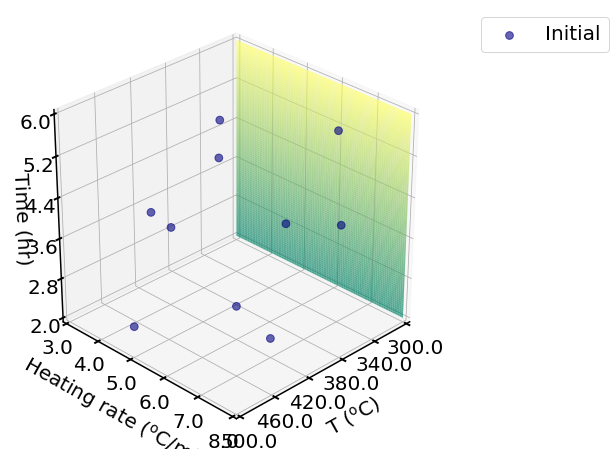

Reponses at fixed x1, varying x2 and x3: 


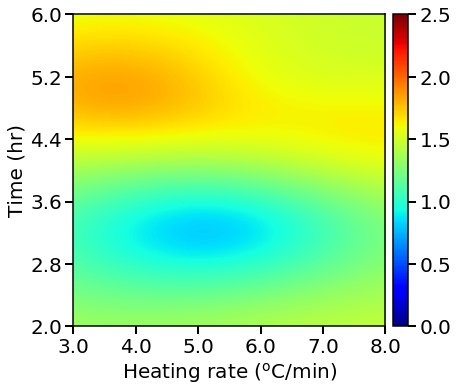

Design space at fixed x2, vary x1 and x3: 


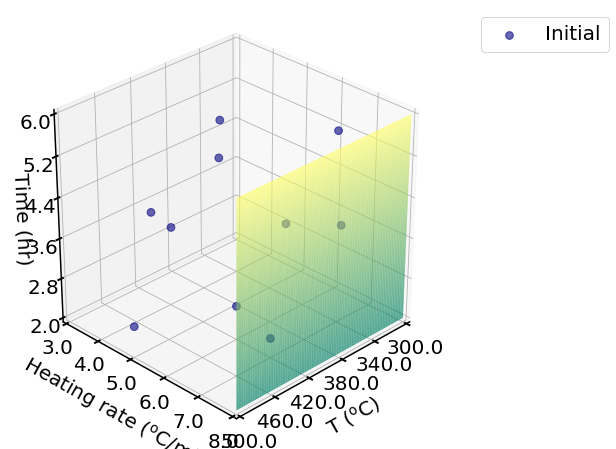

Reponses at fixed x2, varying x2 and x3: 


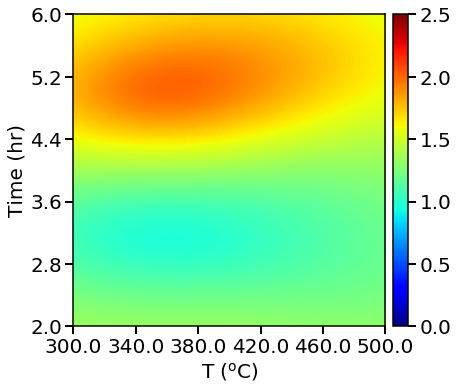

Design space at fixed x3, vary x1 and x2: 


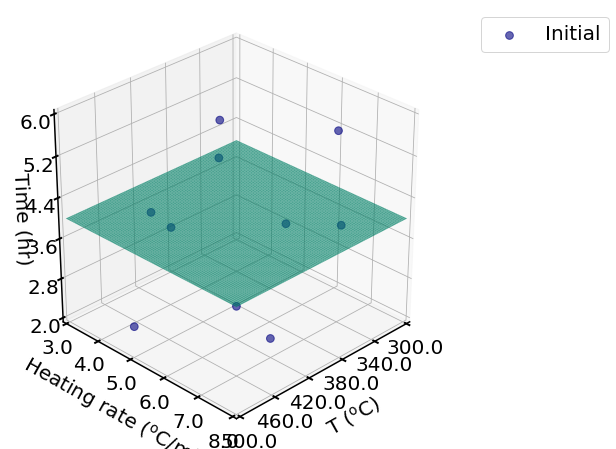

Reponses at fixed x3, varying x1 and x2: 


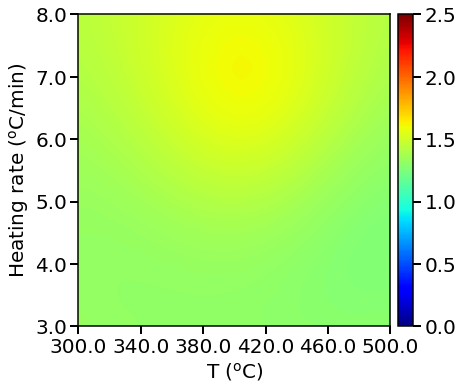

The new data points in iteration 1 are:


,T (C),Heating rate (C/min),Time (hr)
0,300.0,3.0,2.0
1,500.0,3.0,6.0
2,300.0,3.0,6.0


The reponses in iteration 1 are:


,N_Content
0,2.404
1,1.422
2,1.945


Iter 10/100: 1.8419978618621826
Iter 20/100: 1.8229711055755615
Iter 30/100: 1.8088256120681763
Iter 40/100: 1.803086757659912
Iter 50/100: 1.7990056276321411
Iter 60/100: 1.7967737913131714
Iter 70/100: 1.7953238487243652
Iter 80/100: 1.7942073345184326
Iter 90/100: 1.7933542728424072
Iter 100/100: 1.792677640914917
Reponses at fixed x1, vary x2 and x3: 


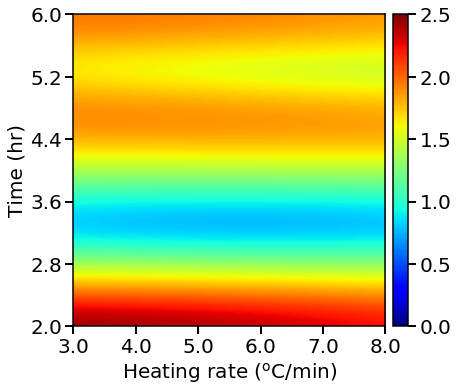

Reponses at fixed x2, vary x1 and x3: 


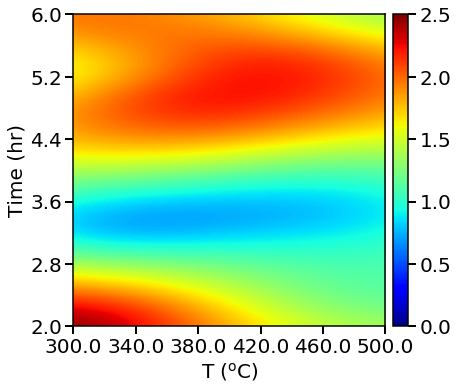

Reponses at fixed x3, vary x1 and x2: 


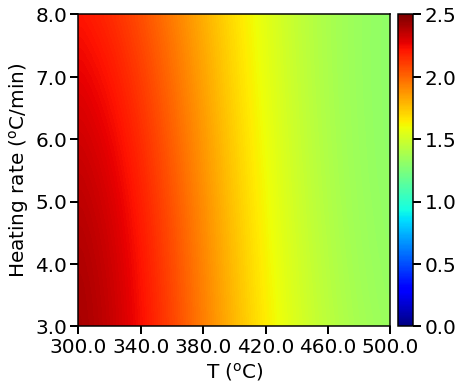

The new data points in iteration 2 are:


,T (C),Heating rate (C/min),Time (hr)
0,500.0,8.0,6.0
1,300.0,8.0,2.0
2,300.0,8.0,6.0


The reponses in iteration 2 are:


,N_Content
0,1.031
1,2.303
2,2.813


Reponses at fixed x1, vary x2 and x3: 


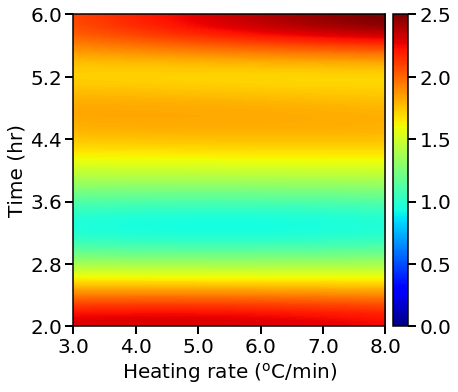

Reponses at fixed x2, vary x1 and x3: 


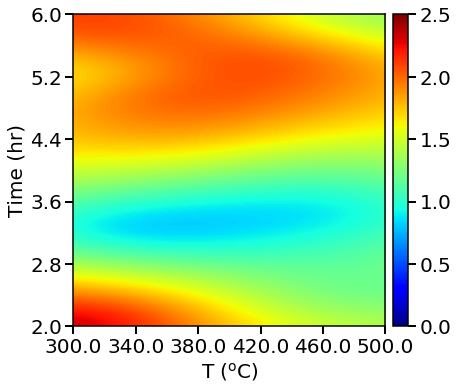

Reponses at fixed x3, vary x1 and x2: 


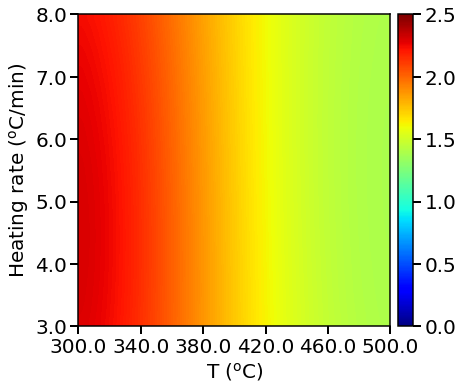

The new data points in iteration 3 are:


,T (C),Heating rate (C/min),Time (hr)
0,490.0,7.75,4.48
1,310.0,3.25,3.55
2,310.0,7.75,2.39


The reponses in iteration 3 are:


,N_Content
0,1.526
1,1.732
2,1.301


Iter 10/100: 1.8066085577011108
Iter 20/100: 1.8050854206085205
Iter 30/100: 1.8036246299743652
Iter 40/100: 1.8028751611709595
Iter 50/100: 1.8024615049362183
Iter 60/100: 1.802217960357666
Iter 70/100: 1.8020403385162354
Iter 80/100: 1.8019156455993652
Iter 90/100: 1.8018176555633545
Iter 100/100: 1.801738977432251
Reponses at fixed x1, vary x2 and x3: 


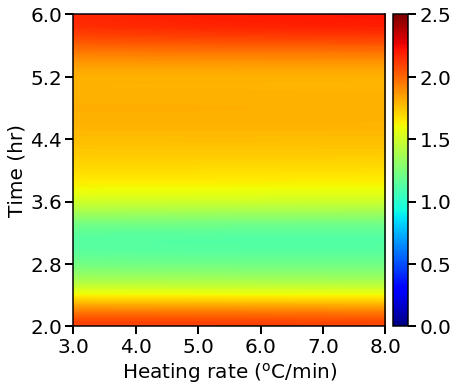

Reponses at fixed x2, vary x1 and x3: 


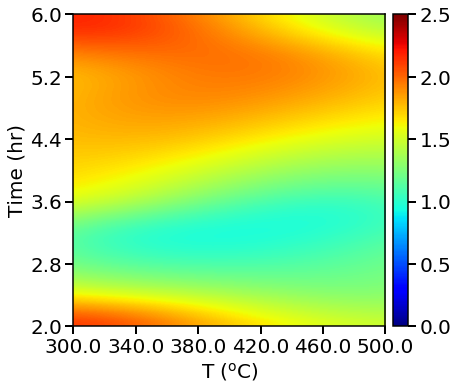

Reponses at fixed x3, vary x1 and x2: 


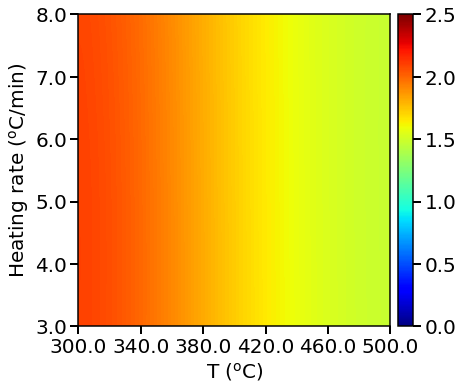

The new data points in iteration 4 are:


,T (C),Heating rate (C/min),Time (hr)
0,479.0,3.25,5.48
1,400.0,7.75,5.48
2,341.0,7.75,2.12


The reponses in iteration 4 are:


,N_Content
0,1.248
1,1.556
2,1.610


Reponses at fixed x1, vary x2 and x3: 


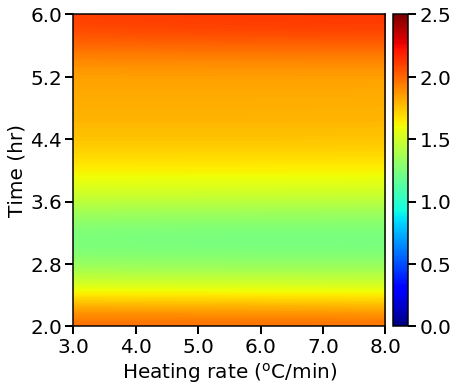

Reponses at fixed x2, vary x1 and x3: 


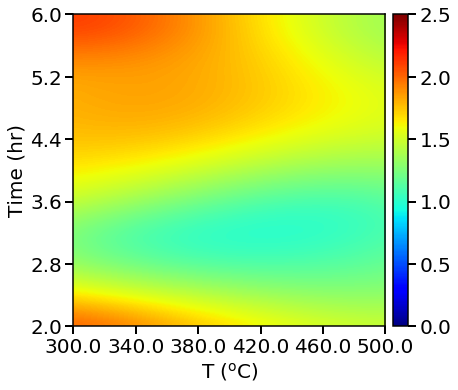

Reponses at fixed x3, vary x1 and x2: 


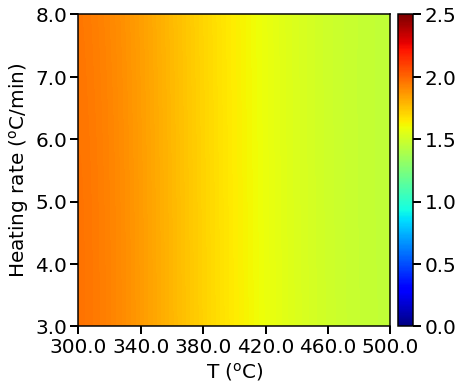

In [5]:
# List for X points in each trial
X_per_trial = [X_init]

# 2D surface for variable 1 and 3 with variable 2 fixed 
x1_fixed_real = 300 # fixed x1 value
x2_fixed_real = 8 # fixed x2 value
x3_fixed_real = np.mean(X_ranges[2]) # fixed x3 value

print('Design space at fixed x1, varying x2 and x3: ')
plotting.sampling_3d_exp(Exp, slice_axis = 'x', slice_value_real = x1_fixed_real)  
print('Reponses at fixed x1, varying x2 and x3: ')
# note that the x_indices starts from 0
plotting.response_heatmap_exp(Exp, Y_real_range = Y_plot_range,  x_indices = [1, 2],
                              fixed_values_real = x1_fixed_real)

print('Design space at fixed x2, vary x1 and x3: ')
plotting.sampling_3d_exp(Exp, slice_axis = 'y', slice_value_real = x2_fixed_real) 
print('Reponses at fixed x2, varying x2 and x3: ')
plotting.response_heatmap_exp(Exp, Y_real_range = Y_plot_range, x_indices = [0, 2],
                              fixed_values_real = x2_fixed_real)

print('Design space at fixed x3, vary x1 and x2: ')
plotting.sampling_3d_exp(Exp, slice_axis = 'z', slice_value_real = x3_fixed_real)   
print('Reponses at fixed x3, varying x1 and x2: ')
plotting.response_heatmap_exp(Exp, Y_real_range = Y_plot_range, x_indices = [0, 1],
                              fixed_values_real = x3_fixed_real)

# Optimization loop
for i in range(1, n_trials+1):
    # Generate the next three experiment point
    # X_new, X_new_real, acq_func = Exp.generate_next_point(3)
    X_new_real = X_real[trial_no == i] # now we just extract the data
    print('The new data points in iteration {} are:'.format(i))
    display(io.np_to_dataframe(X_new_real, X_name_with_unit))
    
    # Convert to a unit scale
    X_new = utils.unitscale_X(X_new_real, X_ranges)
    X_per_trial.append(X_new)
    
    # Get the reponse at this point
    # run the experiments and get the data
    Y_new_real = Y_real[trial_no == i]
    print('The reponses in iteration {} are:'.format(i))
    display(io.np_to_dataframe(Y_new_real, Y_name_with_unit))
     
    
    # Retrain the model by input the next point into Exp object
    Exp.run_trial(X_new, X_new_real, Y_new_real)

    print('Reponses at fixed x1, vary x2 and x3: ')
    plotting.response_heatmap_exp(Exp, Y_real_range = Y_plot_range, x_indices = [1, 2], 
                                  fixed_values_real = x1_fixed_real)
    print('Reponses at fixed x2, vary x1 and x3: ')
    plotting.response_heatmap_exp(Exp, Y_real_range = Y_plot_range, x_indices = [0, 2],
                                  fixed_values_real = x2_fixed_real)
    print('Reponses at fixed x3, vary x1 and x2: ')
    plotting.response_heatmap_exp(Exp, Y_real_range = Y_plot_range, x_indices = [0, 1],
                                  fixed_values_real = x3_fixed_real)

## 6. Visualize the final sampling points
We would like to see how sampling points progresses during the optimization iterations. 

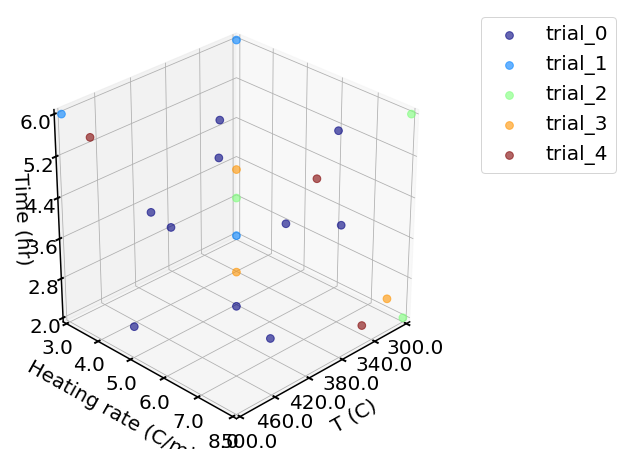

In [6]:
labels = ['trial_' + str(i) for i in range(n_trials+1)]
plotting.sampling_3d(X_per_trial, X_names = X_name_with_unit,  X_ranges = X_ranges, design_names = labels)

## 7. Export the optimum
Obtain the optimum from all sampling points. 

The optimal data points is:


,T (C),Heating rate (C/min),Time (hr),N_Content
0,300.0,8.0,6.0,2.813


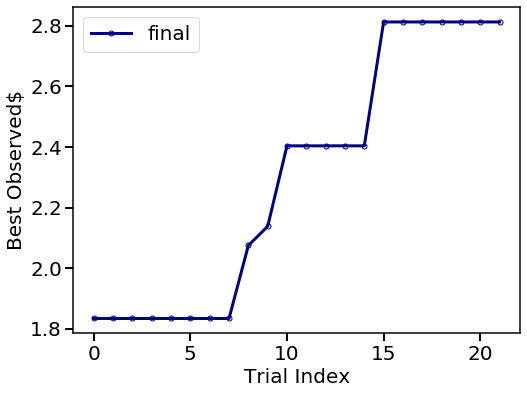

In [8]:
# Plot the optimum discovered in each trial
plotting.opt_per_trial_exp(Exp)
# Extract optimum
y_opt, X_opt, index_opt_lhc = Exp.get_optim()
data_opt = io.np_to_dataframe([X_opt, y_opt], var_names)
print('The optimal data points is:'.format(i))
display(data_opt)

## Reference: 
The data and method in this notebook is based on this paper:

[Ebikade, E. O., Wang, Y., Samulewicz, N., Hasa, B. & Vlachos, D. Active learning-driven quantitative synthesis–structure–property relations for improving performance and revealing active sites of nitrogen-doped carbon for the hydrogen evolution reaction. React. Chem. Eng. (2020). doi:10.1039/D0RE00243G](https://pubs.rsc.org/en/content/articlelanding/2020/re/d0re00243g#!divAbstract)
